In [10]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
path = '../logs/version0/checkpoints/model.pth'
model = torch.load(path)
mode = model.to('cuda')
# x = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
target_layers = [model.Mixed_7c]# inception
# target_layers = [model.features] # VGG
# target_layers = [model.layer4[-1]] # resnet
# target_layers = [model.layers.maxpool5] # DRNet-Qv2
# target_layers = [model.stage4.layers[0][1].mlp_block.fn.norm] #Swin-Transformer
# target_layers = [model.levels[-1].blocks[-1].norm1] # NAT
# print(target_layers)


1


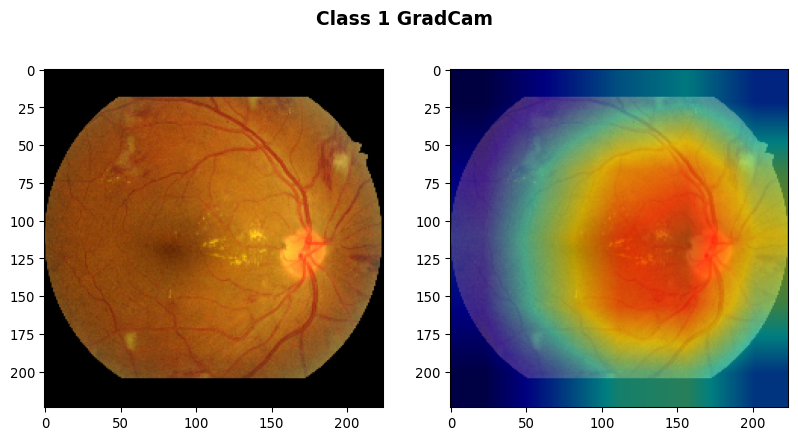

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def reshape_transform(tensor):
    result = tensor.transpose(2, 3).transpose(1, 2)
    return result

rgb = cv2.imread('../dataset/PulbicDatasets/full/Crop/Images/IDRiD_22.jpg')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb = cv2.resize(rgb, (224,224))
rgb = np.array(rgb) / 255.

image = rgb.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)

input_tensor = torch.Tensor(image).to('cuda')
pred = model(input_tensor)
pred = torch.softmax(pred, dim=1)
pred = torch.argmax(pred).item()
print(pred)

# cam = GradCAM(model, target_layers, use_cuda=True, reshape_transform=reshape_transform)
cam = GradCAM(model, target_layers, use_cuda=True)
rgb = input_tensor.detach().cpu()
grayscale_cam = cam(input_tensor=rgb, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb.squeeze(0).numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
vis_img = Image.fromarray(visualization).convert('RGB')
vis_tensor = torch.tensor(visualization.transpose(2, 0, 1), dtype=torch.float, device='cuda')

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=96)
ax[0].imshow(rgb.squeeze(0).numpy().transpose(1, 2, 0))
ax[1].imshow(np.array(vis_img))
fig.suptitle('Class 1 GradCam', fontsize=14, fontweight="bold")
plt.show()


1


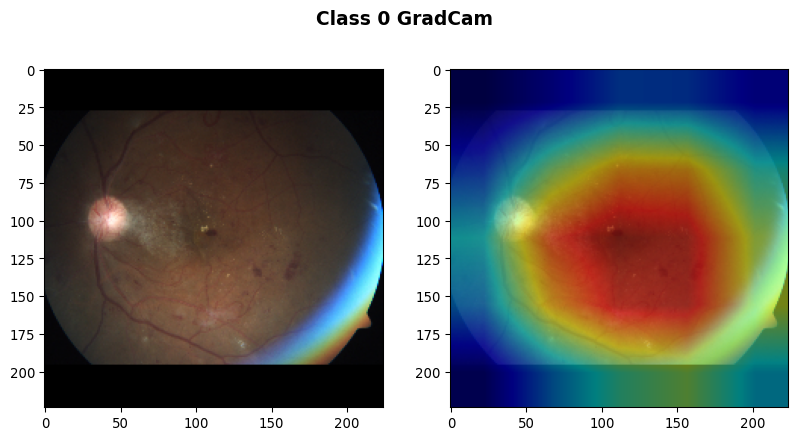

In [12]:
# rgb = cv2.imread('../dataset/D2/test/0/4627_right.jpeg')
rgb = cv2.imread('../dataset/PulbicDatasets/full/Crop/Images/0ada12c0e78f.png')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb = cv2.resize(rgb, (224,224))
rgb = np.array(rgb) / 255.

image = rgb.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)

input_tensor = torch.Tensor(image).to('cuda')
pred = model(input_tensor)
pred = torch.softmax(pred, dim=1)
pred = torch.argmax(pred).item()
print(pred)
# cam = GradCAM(model, target_layers, use_cuda=True, reshape_transform=reshape_transform)
cam = GradCAM(model, target_layers, use_cuda=True)
rgb = input_tensor.detach().cpu()
grayscale_cam = cam(input_tensor=rgb, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb.squeeze(0).numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
vis_img = Image.fromarray(visualization).convert('RGB')
vis_tensor = torch.tensor(visualization.transpose(2, 0, 1), dtype=torch.float, device='cuda')

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=96)
ax[0].imshow(rgb.squeeze(0).numpy().transpose(1, 2, 0))
ax[1].imshow(np.array(vis_img))
fig.suptitle('Class 0 GradCam', fontsize=14, fontweight="bold")
plt.show()



100%|█████████████████████████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.32it/s]


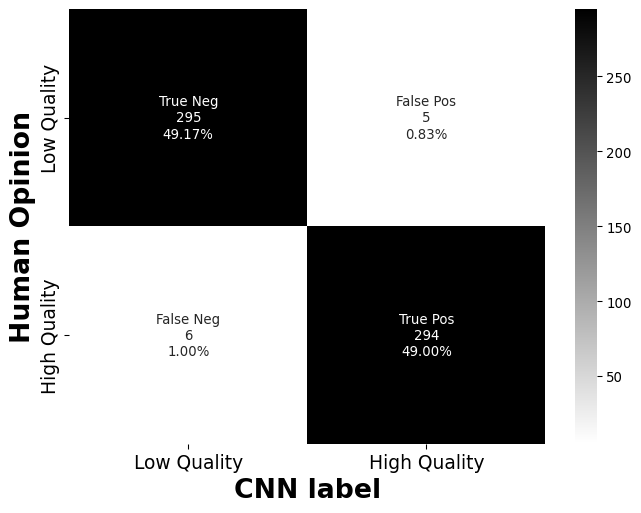

In [20]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from torchvision import datasets, transforms
import os


def plot_confusion_matrix(net, loader, device):
    net.eval()
    y_pred = []  # save predction
    y_true = []  # save ground truth
    loop = tqdm(loader, ncols=120)
    for _, (inputs, labels) in enumerate(loop):
        inputs = inputs.type(torch.float).to(device)
        labels = labels.type(torch.long).to(device)
        output = net(inputs)  # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth
    # constant for classes
    classes = ('Low-Quality', 'High-Quality')
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    
    fig = plt.figure(figsize=(8, 6))
    fig.set_dpi(96)
    ax = sns.heatmap(cf_matrix, annot=labels, cmap='binary', fmt='')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Low Quality', 'High Quality'], fontsize=14)
    ax.yaxis.set_ticklabels(['Low Quality', 'High Quality'], fontsize=14)
    ax.set_xlabel('CNN label', fontsize=20, fontweight="bold")
    ax.set_ylabel('Human Opinion', fontsize=20, fontweight="bold")
    plt.savefig('../images/test_cfmatrix.png')


test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(
    '../dataset/D2/test/', transform=test_transforms
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
plot_confusion_matrix(model, test_loader, 'cuda')
